In [1]:
import safep
import alchemlyb
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os

from IPython.display import display, Markdown

from alchemlyb.estimators import BAR
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# User parameters

In [41]:
path='/Users/ezry/Projects/SAFEP_tutorial/stepD_alchemy_bulk/sample_outputs/'
filename='*.fepout'

temperature = 303.15
RT = 0.00198720650096 * temperature
decorrelate = True #Flag for decorrelation of samples
detectEQ = True #Flag for automated equilibrium detection

fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 1 fepout files.
Total size:0.01GB


# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

In [42]:
u_nk = safep.read_and_process(fepoutFiles, temperature, decorrelate, detectEQ) #u_nk stores the fep data
perWindow, cumulative = safep.do_estimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = safep.do_convergence(u_nk) #Used later in the convergence plot'

Detecting Equilibrium
Decorrelating samples. Flag='True'


In [43]:
from alchemlyb.parsing import namd

In [44]:
u_nk = namd.extract_u_nk(fepoutFiles, temperature)
samples = safep.get_n_samples(u_nk)

equilibrated = safep.detect_equilibrium_u_nk(u_nk)
samples_eq = safep.get_n_samples(equilibrated)

decorrelated = safep.decorrelate_u_nk(equilibrated)
samples_decorr = safep.get_n_samples(decorrelated)

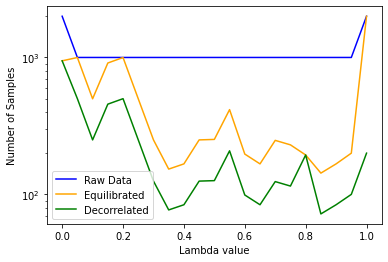

In [45]:
fig, ax = plt.subplots()
ax.plot(samples, color='blue', label='Raw Data')
ax.plot(samples_eq, color='orange', label='Equilibrated')
ax.plot(samples_decorr, color='green', label='Decorrelated')
plt.yscale('log')
ax.set_ylabel('Number of Samples')
ax.set_xlabel('Lambda value')
ax.legend()

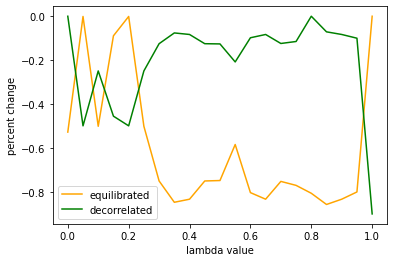

In [46]:
fig, ax = plt.subplots()
ax.plot(np.divide(samples_eq-samples, samples), color='orange', label='equilibrated')
ax.plot(np.divide(samples_decorr-samples_eq, samples), color='green', label='decorrelated')
ax.set_ylabel('percent change')
ax.set_xlabel('lambda value')
ax.legend()

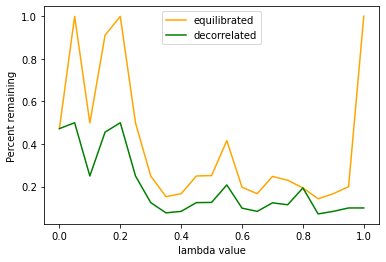

In [47]:
fig, ax = plt.subplots()
ax.plot(np.divide(samples_eq, samples), color='orange', label='equilibrated')
ax.plot(np.divide(samples_decorr, samples), color='green', label='decorrelated')
ax.set_ylabel('Percent remaining')
ax.set_xlabel('lambda value')
ax.legend()

In [4]:
dG = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)

changeAndError = f'\u0394G = {dG}\u00B1{error} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

<font size=5>ΔG = 61.4±0.6 kcal/mol</font><br/>

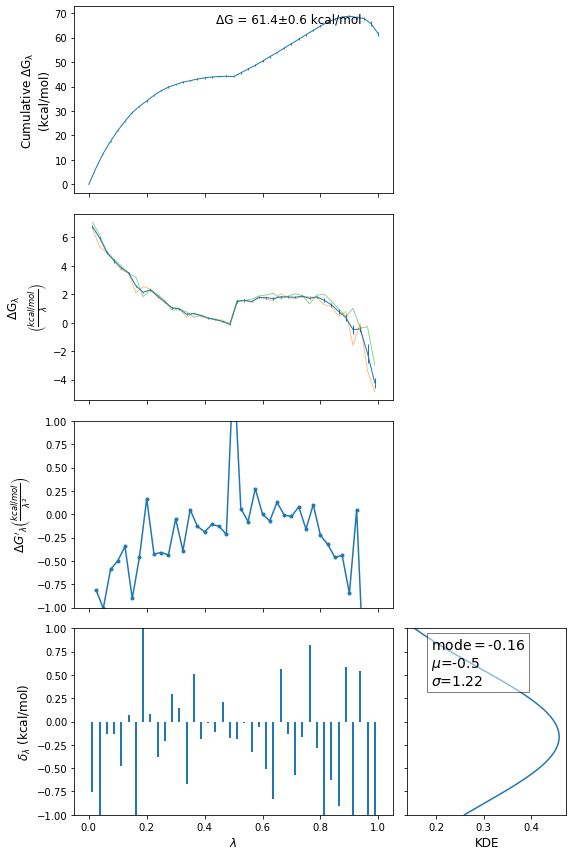

In [5]:
fig, axes = safep.plot_general(cumulative, None, perWindow, None, RT)
fig.suptitle(changeAndError)
plt.savefig(f'{path}FEP_general_figures.pdf')

# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

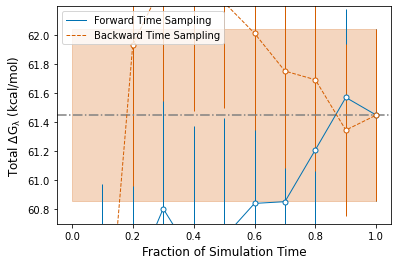

In [6]:
fig, convAx = plt.subplots(1,1)
convAx = safep.convergence_plot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT)
plt.savefig(f'{path}FEP_convergence.pdf')